In [1]:
from fastai.vision import *

# Preparing Fruits Image DataSet

In [ ]:
folders = ['grapes', 'mango', 'tomato', 'watermelon', 'muskmelon', 'strawberry', 'banana', 'avocado', 'figs', 
           'jackfruit', 'orange', 'lemon', 'kiwi', 'dates']
files = ['urls_grapes.csv','urls_mangoes.csv', 'urls_tomatoes.csv', 'urls_watermelons.csv', 'urls_muskmelons.csv', 
         'urls_strawberries.csv', 'urls_bananas.csv', 'urls_avocados.csv', 'urls_figs.csv', 
         'urls_jackfruits.csv', 'urls_oranges.csv', 'urls_lemons.csv', 'urls_kiwis.csv', 'urls_dates.csv']

In [3]:
path = Path("D:\\MLAndDL\\FastAI\\data\\fruits")

In [ ]:
for folder in folders:
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [ ]:
classes = ['grapes', 'mango', 'tomato', 'watermelon', 'muskmelon', 'strawberry', 'banana', 'avocado', 'figs', 
           'jackfruit', 'orange', 'lemon', 'kiwi', 'dates']

In [ ]:
for (file,folder) in zip(files,folders):
    print(f"downloading {folder} images")
    download_images(path/file, path/folder, max_pics=200)

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# Creating Databunch object

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2, 
                                  ds_tfms = get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes

['avocado',
 'banana',
 'dates',
 'figs',
 'grapes',
 'jackfruit',
 'kiwi',
 'lemon',
 'mango',
 'muskmelon',
 'orange',
 'strawberry',
 'tomato',
 'watermelon']

In [ ]:
data.show_batch(rows=4, figsize = (7,8))

In [6]:
len(data.train_ds), len(data.valid_ds), data.c, data.classes

(2240,
 560,
 14,
 ['avocado',
  'banana',
  'dates',
  'figs',
  'grapes',
  'jackfruit',
  'kiwi',
  'lemon',
  'mango',
  'muskmelon',
  'orange',
  'strawberry',
  'tomato',
  'watermelon'])

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [8]:
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,error_rate,time
0,2.717280,0.978645,0.296429,01:08
1,1.483683,0.685999,0.221429,01:04
2,0.989908,0.670926,0.191071,01:05
3,0.677685,0.617887,0.178571,01:06
4,0.525145,0.631042,0.178571,01:03
5,0.414761,0.584180,0.175000,01:03
6,0.346122,0.572807,0.167857,01:06


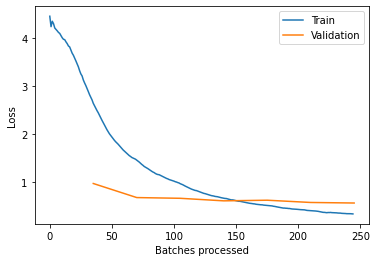

In [9]:
learn.recorder.plot_losses()

In [10]:
learn.save('fruits-stage-1')

In [15]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


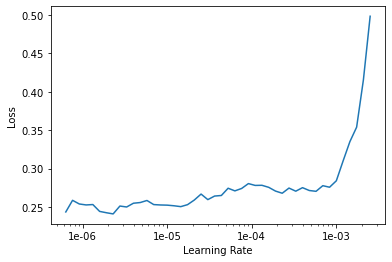

In [13]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.203958,0.557060,0.141071,01:31
1,0.170220,0.514274,0.132143,01:31


In [17]:
learn.save('fruits-stage-2')

# Interpretation

In [18]:
learn.load('fruits-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2240 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
avocado,avocado,avocado,avocado,avocado
Path: D:\MLAndDL\FastAI\data\fruits;

Valid: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jackfruit,figs,orange,jackfruit,muskmelon
Path: D:\MLAndDL\FastAI\data\fruits;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batch

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

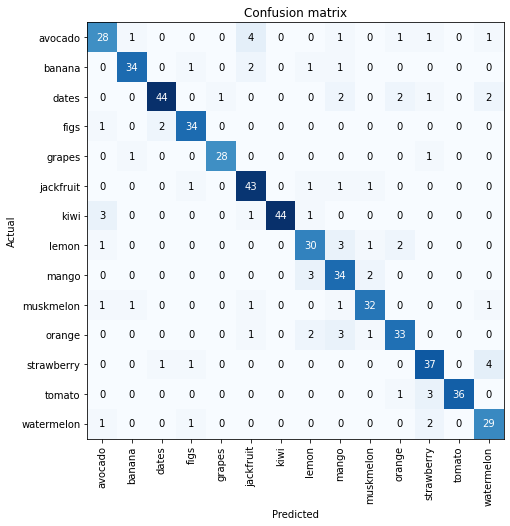

In [21]:
interp.plot_confusion_matrix(figsize= (7,8))

In [22]:
interp.most_confused(min_val=2)

[('avocado', 'jackfruit', 4),
 ('strawberry', 'watermelon', 4),
 ('kiwi', 'avocado', 3),
 ('lemon', 'mango', 3),
 ('mango', 'lemon', 3),
 ('orange', 'mango', 3),
 ('tomato', 'strawberry', 3),
 ('banana', 'jackfruit', 2),
 ('dates', 'mango', 2),
 ('dates', 'orange', 2),
 ('dates', 'watermelon', 2),
 ('figs', 'dates', 2),
 ('lemon', 'orange', 2),
 ('mango', 'muskmelon', 2),
 ('orange', 'lemon', 2),
 ('watermelon', 'strawberry', 2)]

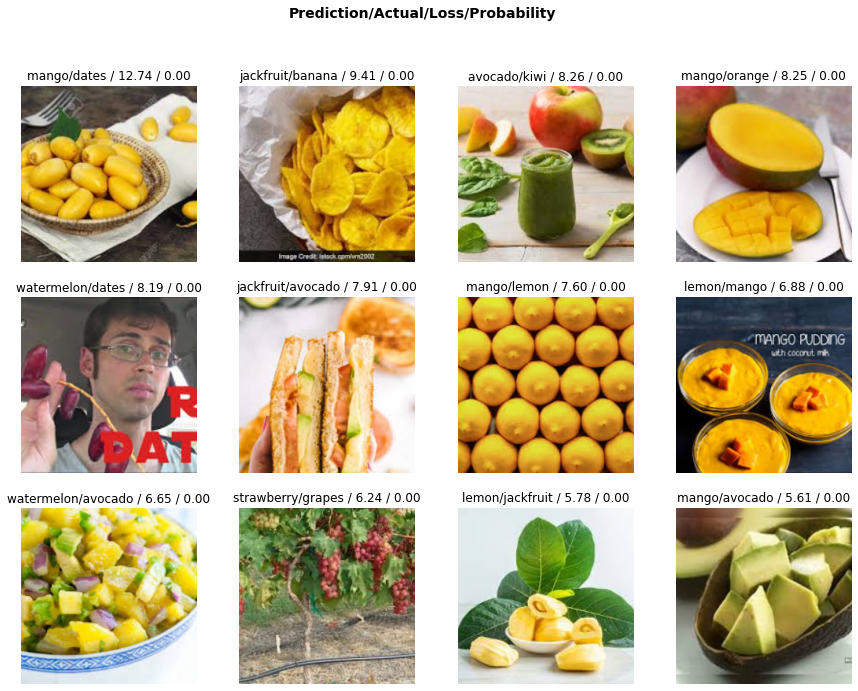

In [24]:
interp.plot_top_losses(12, figsize= (15,11))

# Cleaning up

In [25]:
from fastai.widgets import *

In [30]:
db = (ImageList.from_folder(path)
            .split_none()
            .label_from_folder()
            .transform(get_transforms(), size=224)
            .databunch())

In [35]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('fruits-stage-2');

In [32]:
ds, idxs = DatasetFormatter.from_toplosses(learn_cln)

In [33]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [34]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                .split_none()
                .label_from_df()
                .transform(get_transforms(), size=224)
                .databunch()
      )

In [36]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [37]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [38]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=16).normalize(imagenet_stats)

In [39]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [41]:
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.896949,0.726247,0.210227,01:05
1,1.158805,0.571924,0.155303,01:05
2,0.840094,0.531073,0.153409,01:05
3,0.670627,0.523673,0.143939,01:04
4,0.538402,0.408898,0.123106,01:04
5,0.448191,0.390906,0.126894,01:05
6,0.385368,0.404514,0.125000,01:05


In [42]:
learn.save('fruits-stage-3')

In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(2, max_lr= slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.266011,0.353933,0.090909,01:20
1,0.203183,0.354787,0.094697,01:20


In [48]:
learn.save('fruits-stage-4')

In [49]:
learn.export()

In [50]:
interp=ClassificationInterpretation.from_learner(learn)

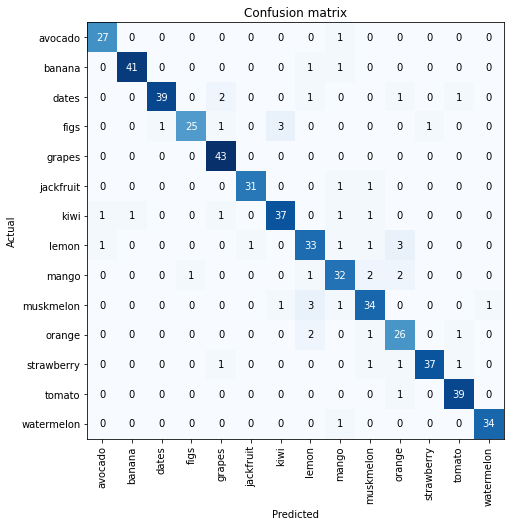

In [51]:
interp.plot_confusion_matrix(figsize=(7,8))

In [52]:
interp.most_confused(min_val=2)

[('figs', 'kiwi', 3),
 ('lemon', 'orange', 3),
 ('muskmelon', 'lemon', 3),
 ('dates', 'grapes', 2),
 ('mango', 'muskmelon', 2),
 ('mango', 'orange', 2),
 ('orange', 'lemon', 2)]

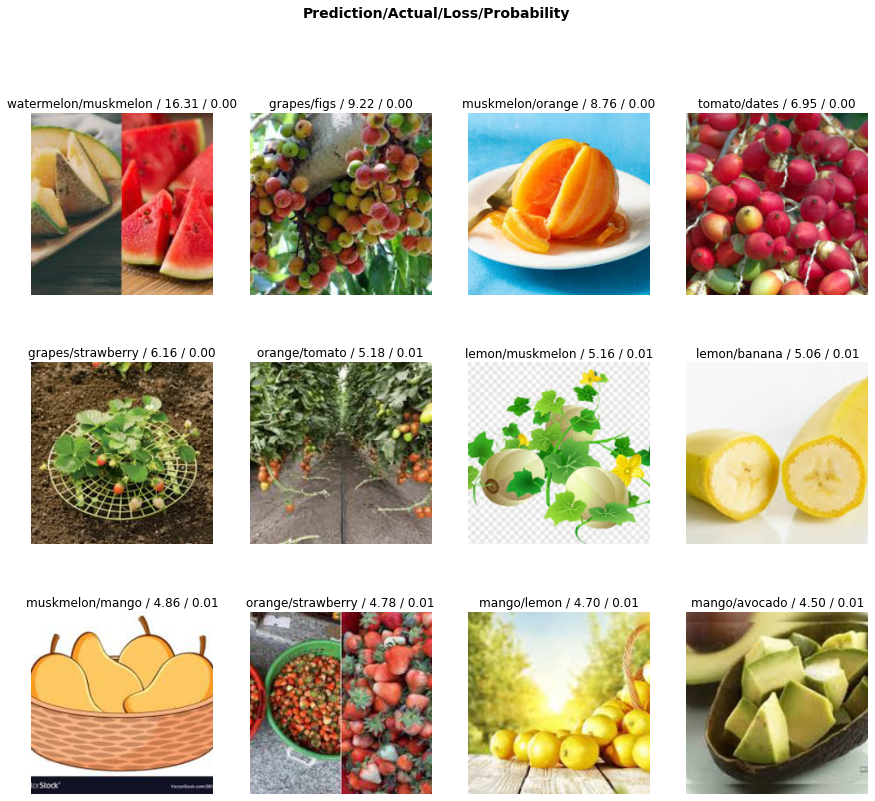

In [54]:
interp.plot_top_losses(12, figsize=(15,13))